In [202]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# EDA

In [203]:
#Importing dataset
df_INR = pd.read_csv("DEXINUS.csv")

In [204]:
df_INR.head()

,DATE,DEXINUS
0,2018-06-25,68.09
1,2018-06-26,68.31
2,2018-06-27,68.63
3,2018-06-28,68.81
4,2018-06-29,68.46


In [205]:
df_INR.columns

Index(['DATE', 'DEXINUS'], dtype='object')

In [206]:
df_INR.dtypes

DATE       object
DEXINUS    object
dtype: object

In [207]:
df_INR.shape

(1305, 2)

In [208]:
df_INR = df_INR.loc[df_INR['DEXINUS'] != '.' ]

In [209]:
df_INR.shape

In [210]:
df_INR['DEXINUS'] = df_INR['DEXINUS'].astype(float)

In [211]:
# converting date to datetime64[ns] type
df_INR['DATE'] = pd.to_datetime(df_INR['DATE'], format='%Y-%m-%d', dayfirst=True)

In [212]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [213]:
# We can get date month and year part from the date column
df_INR['month'] = df_INR['DATE'].dt.month
df_INR['year'] = df_INR['DATE'].dt.year
df_INR['day'] = df_INR['DATE'].dt.day
df_INR['day_of_week'] = df_INR['DATE'].dt.weekday

In [214]:
df_INR.head()

,DATE,DEXINUS,month,year,day,day_of_week
0,2018-06-25,68.09,6,2018,25,0
1,2018-06-26,68.31,6,2018,26,1
2,2018-06-27,68.63,6,2018,27,2
3,2018-06-28,68.81,6,2018,28,3
4,2018-06-29,68.46,6,2018,29,4


In [215]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [216]:
df_INR.shape

(1246, 6)

# Chaos Test - Will be adding later

# ADF Test

In [217]:
# check for Stationarity - ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_INR['DEXINUS'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.8680852069320087
p-value: 0.7983006912640636
Critial Values:
   1%, -3.435638861796935
Critial Values:
   5%, -2.863875547501718
Critial Values:
   10%, -2.5680134763122906


In [218]:
"""
From ADF test, it's observed that, data is not stationary. 
We can see p-value is 23% (usually it must be less than 0.05 or 5%), 
and ADF-stat value is greater than all the critical values. 

Both these values confirms the data to be Non-Stationary
"""

"\nFrom ADF test, it's observed that, data is not stationary. \nWe can see p-value is 23% (usually it must be less than 0.05 or 5%), \nand ADF-stat value is greater than all the critical values. \n\nBoth these values confirms the data to be Non-Stationary\n"

# Splitting the dataset

In [219]:
X = df_INR.iloc[:, 2:].values
y = df_INR.iloc[:, 1].values

In [220]:
X.shape

(1246, 4)

In [221]:
y.shape

(1246,)

In [222]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [223]:
# SMAPE function - Symmetric mean absolute percentage error
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [224]:
# Direction Symmetry - It gives the percentage of occurrences in which the sign of the change in value from one time period to the next is the same for both the actual and predicted time series
def ds(A, F):
    sum_A = 0
    for i in range(1, len(A)):
        sum_A += 1 if (A[i]-A[i-1])*(F[i]-F[i-1])>0 else 0
    return (100*sum_A)/(len(A)-1)

In [225]:
# Theil's U coefficient - The greater accuracy of the forecast, the lower will be the value of the u1
def u1(A,F):
    data = pd.DataFrame({'A_i':A, 'F_i': F})
    data['(A_i - F_i)^2'] = np.square(data['A_i'] - data['F_i'])
    data['F_i^2'] = np.square(data['F_i'])
    data['A_i^2'] = np.square(data['A_i'])
    return (np.sqrt(np.mean(data['(A_i - F_i)^2'])))/(np.sqrt(np.mean(data['F_i^2']))+np.sqrt(np.mean(data['A_i^2'])))

# Linear Regression

In [226]:
# Fitting Linear Regression in dataset
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [227]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7832330351945896
MSE 3.6264182169951598
RMSE 1.9043156820745766


 SMAPE prediction

In [228]:
print(smape(y_test, y_pred))

2.2004150914740785


 Direction Symmetry prediction

In [229]:
print(ds(y_test, y_pred))

82.63665594855306


 Theil's U coefficient prediction

In [230]:
print(u1(y_test, y_pred))

0.012679777380980126


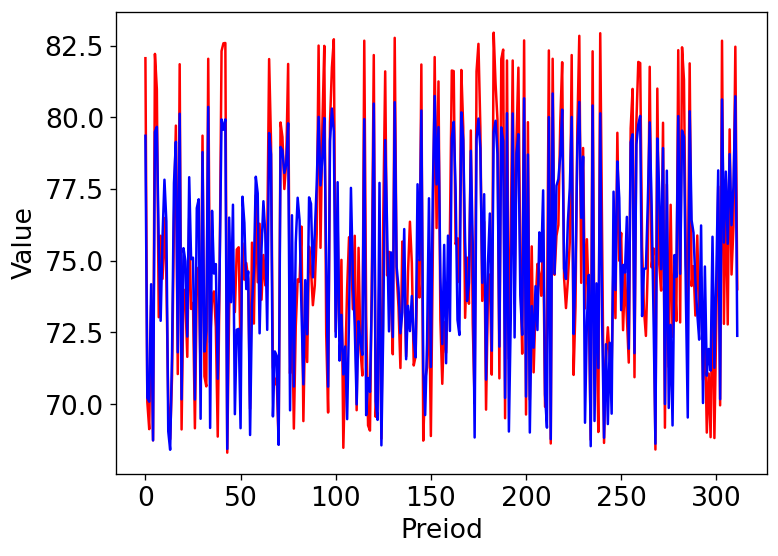

In [231]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Polynomial Regression

In [232]:
# Fitting Polynomial Regression in dataset
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)

In [233]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.8330889782069669
MSE 2.7923497041668393
RMSE 1.6710325263641157


 SMAPE prediction

In [234]:
print(smape(y_test, y_pred))

1.7295808887461988


 Direction Symmetry prediction

In [235]:
print(ds(y_test, y_pred))

82.31511254019293


 Theil's U coefficient prediction

In [236]:
print(u1(y_test, y_pred))

0.011125735160945107


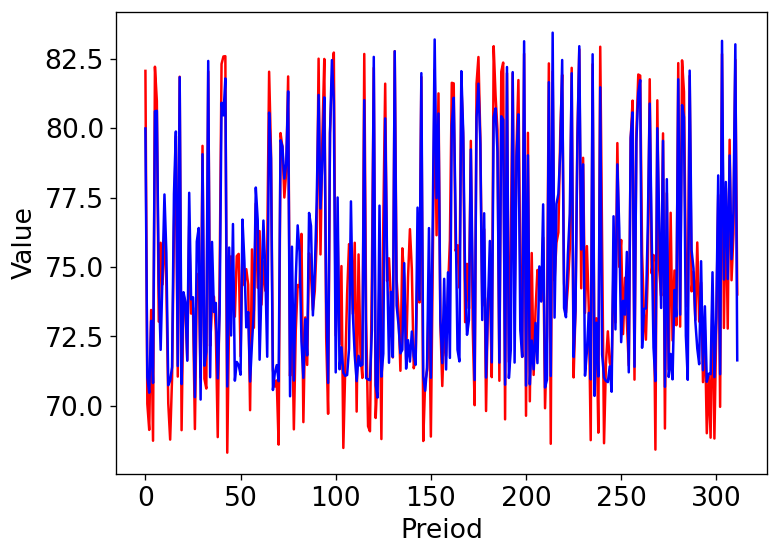

In [237]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Decision Tree Regression

In [238]:
# Fitting Decision Tree Regression in dataset
from sklearn.tree import DecisionTreeRegressor 

regressor = DecisionTreeRegressor(random_state = 0) 

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [239]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9914038668538935
MSE 0.14380961538461576
RMSE 0.37922238249425066


 SMAPE prediction

In [240]:
print(smape(y_test, y_pred))

0.3363690601753106


 Direction Symmetry prediction

In [241]:
print(ds(y_test, y_pred))

97.42765273311898


 Theil's U coefficient prediction

In [242]:
print(u1(y_test, y_pred))

0.0025223856160251088


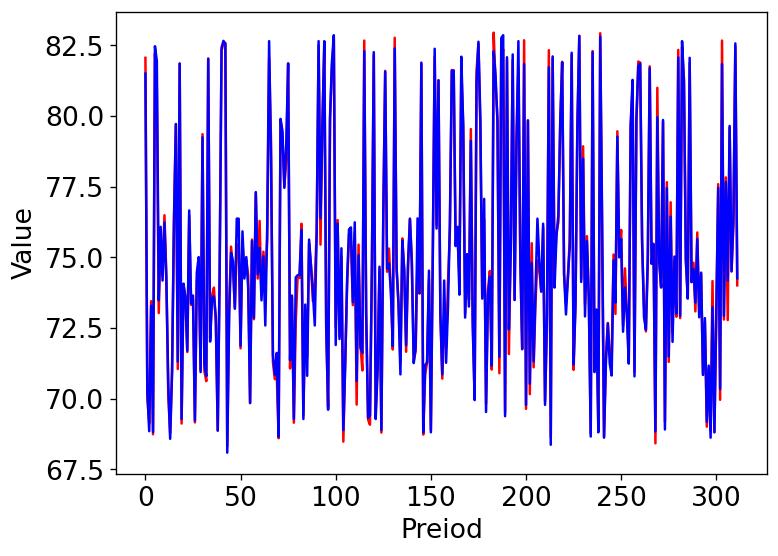

In [243]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

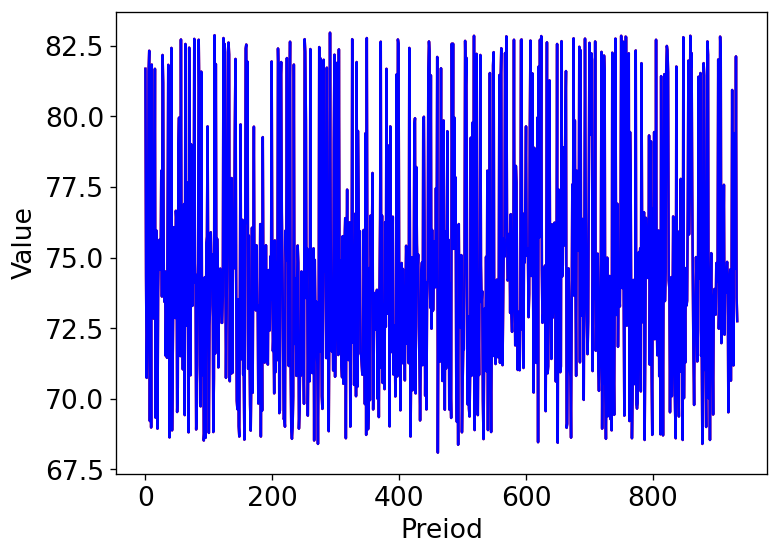

In [244]:
# It is overfitted
plt.rc("figure")
plt.plot(y_train, color="r")
plt.plot(regressor.predict(X_train), color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Random Forest Regression

In [245]:
from sklearn.ensemble import RandomForestRegressor

In [246]:
model = RandomForestRegressor()

In [247]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 4],
              "n_estimators": [100, 300, 1000]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'max_depth': 4, 'n_estimators': 100}


In [248]:
# Fitting Random Forest Regression in dataset
regressor = RandomForestRegressor(n_estimators  = search.best_params_["n_estimators"],
                                   max_depth     = search.best_params_["max_depth"])

regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)

In [249]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.963296413135049
MSE 0.6140352435880048
RMSE 0.7836040094256823


 SMAPE prediction

In [250]:
print(smape(y_test, y_pred))

0.7988794790430926


 Direction Symmetry prediction

In [251]:
print(ds(y_test, y_pred))

89.38906752411576


 Theil's U coefficient prediction

In [252]:
print(u1(y_test, y_pred))

0.005211574907455898


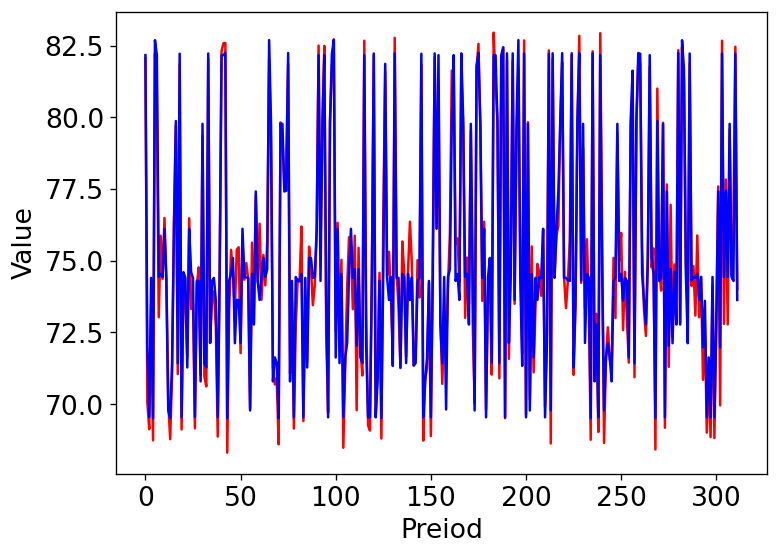

In [253]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

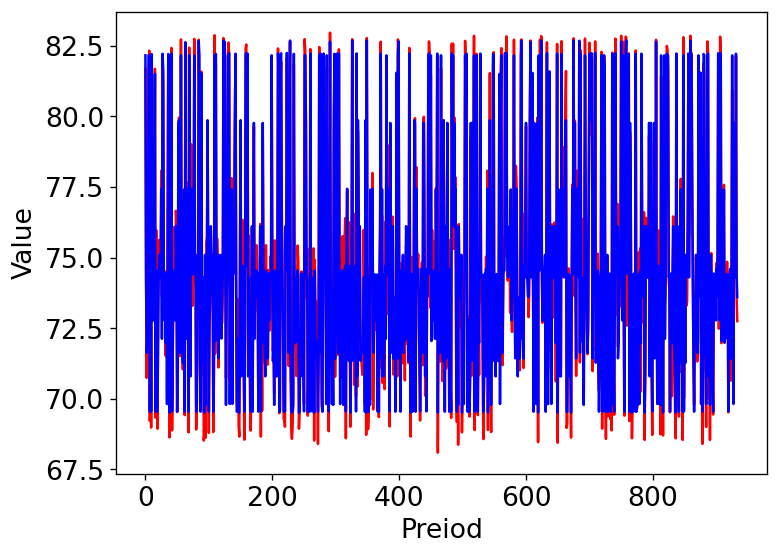

In [254]:
# It is not overfitted
plt.rc("figure")
plt.plot(y_train, color="r")
plt.plot(regressor.predict(X_train), color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# XGB Regression

In [255]:
from xgboost import XGBRegressor

In [256]:
model = XGBRegressor()

In [257]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
              "n_estimators": [100, 300, 1000],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 10, 'n_estimators': 1000}


In [258]:
regressor = XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [259]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9916083006376308
MSE 0.14038952598962987
RMSE 0.37468590311036504


 SMAPE prediction

In [260]:
print(smape(y_test, y_pred))

0.33703147226447183


 Direction Symmetry prediction

In [261]:
print(ds(y_test, y_pred))

96.46302250803859


 Theil's U coefficient prediction

In [262]:
print(u1(y_test, y_pred))

0.0024932007369518998


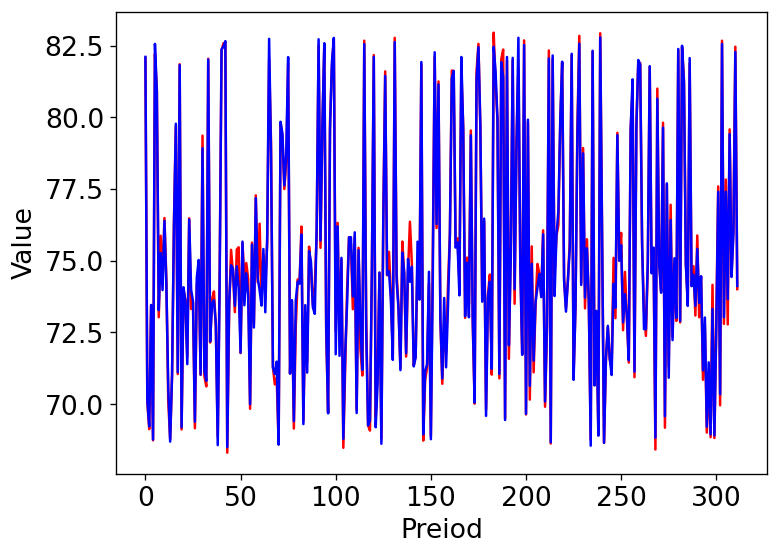

In [263]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# SGD Regression

In [264]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [265]:
from sklearn.pipeline import Pipeline

# Create a Pipeline object
sgd_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor()),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'sgd__alpha': [0.5, 0.3, 0.2, 0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': np.arange(0, 1.1, 0.1), 
              'sgd__max_iter':[100, 200, 500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
              'sgd__warm_start': [True, False]
            }

# Create a GridSearchCV object and perform hyperparameter tuning
sgdr = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgdr.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgdr = sgdr.best_params_

print("Best Score (negative mean squared error): %f" % sgdr.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgdr)

Fitting 3 folds for each of 7392 candidates, totalling 22176 fits
Best Score (negative mean squared error): -3.525484
Optimal Hyperparameter Values:  {'sgd__alpha': 0.001, 'sgd__eta0': 0.001, 'sgd__l1_ratio': 0.7000000000000001, 'sgd__learning_rate': 'constant', 'sgd__max_iter': 1000, 'sgd__warm_start': True}


In [266]:
y_pred = sgdr.predict(X_test)

In [267]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7831575574898646
MSE 3.6276809265765664
RMSE 1.904647192153068


 SMAPE prediction

In [268]:
print(smape(y_test, y_pred))

2.2021796273361476


 Direction Symmetry prediction

In [269]:
print(ds(y_test, y_pred))

82.63665594855306


 Theil's U coefficient prediction

In [270]:
print(u1(y_test, y_pred))

0.012682008329002651


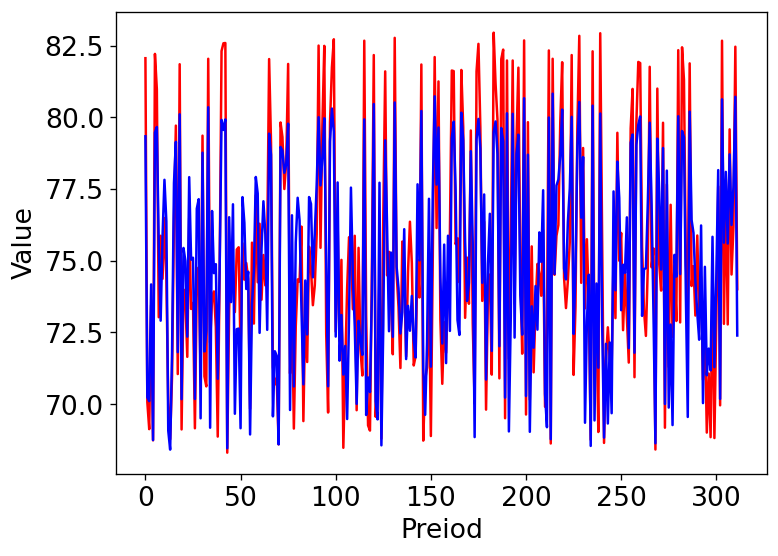

In [271]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# LSTM

In [272]:
# Splitting the dataset into the Training set and Test set
X = df_INR.iloc[:, 2:].values
y = df_INR.iloc[:, 1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [273]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler

sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = MinMaxScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [274]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [275]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, 4)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 100)            42000     
                                                                 
 dense_3 (Dense)             (None, 1, 1)              101       
                                                                 
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


In [276]:
# fit model
X_train = np.reshape(X_train, (X_train.shape[0], 1, 4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 4))
history = model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=1, validation_split=0.1)

Epoch 1/5
840/840 [==============================] - 7s 5ms/step - loss: 0.0357 - val_loss: 0.0187
Epoch 2/5
840/840 [==============================] - 4s 5ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 3/5
840/840 [==============================] - 4s 5ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 4/5
840/840 [==============================] - 4s 5ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 5/5
840/840 [==============================] - 4s 5ms/step - loss: 0.0132 - val_loss: 0.0122


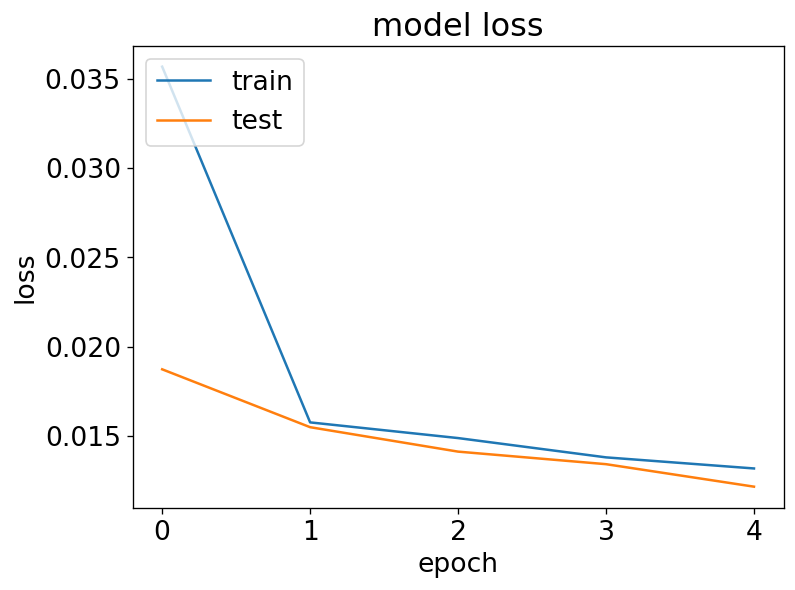

In [277]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [278]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict.reshape(-1,1))

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

10/10 [==============================] - 0s 4ms/step
Shape of train and test predict:  (934, 1, 1) (312, 1)


In [279]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict.reshape(-1,1))
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.10810681002326473 1.690848322056736


In [280]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7831575574898646
MSE 3.6276809265765664
RMSE 1.904647192153068


 SMAPE prediction

In [281]:
print(smape(y_test, y_pred))

2.2021796273361476


 Direction Symmetry prediction

In [282]:
print(ds(y_test, y_pred))

82.63665594855306


 Theil's U coefficient prediction

In [283]:
print(u1(y_test, y_pred))

0.012682008329002651


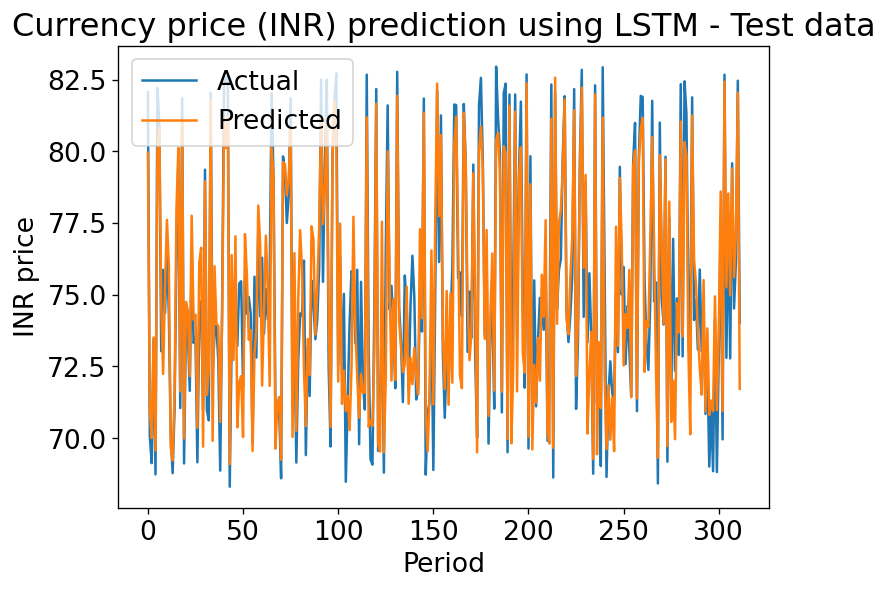

In [284]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# ANN 1-10-1

In [285]:
# Splitting the dataset
X = df_INR.iloc[:, 0].values
y = df_INR.iloc[:, 1].values

In [286]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [287]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train.reshape(-1,1))
X_test = sc_X.transform(X_test.reshape(-1,1))

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [288]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(10, activation = 'relu', input_dim = 1))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                20        
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [289]:
# fit model
history = model.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1, validation_split=0.1)

Epoch 1/25
84/84 [==============================] - 1s 8ms/step - loss: 1.2602 - val_loss: 1.1070
Epoch 2/25
84/84 [==============================] - 0s 5ms/step - loss: 1.1361 - val_loss: 1.0104
Epoch 3/25
84/84 [==============================] - 0s 4ms/step - loss: 1.0372 - val_loss: 0.9330
Epoch 4/25
84/84 [==============================] - 0s 4ms/step - loss: 0.9545 - val_loss: 0.8635
Epoch 5/25
84/84 [==============================] - 0s 4ms/step - loss: 0.8821 - val_loss: 0.8034
Epoch 6/25
84/84 [==============================] - 0s 4ms/step - loss: 0.8212 - val_loss: 0.7523
Epoch 7/25
84/84 [==============================] - 0s 4ms/step - loss: 0.7713 - val_loss: 0.7093
Epoch 8/25
84/84 [==============================] - 0s 5ms/step - loss: 0.7313 - val_loss: 0.6747
Epoch 9/25
84/84 [==============================] - 0s 4ms/step - loss: 0.6996 - val_loss: 0.6451
Epoch 10/25
84/84 [==============================] - 0s 4ms/step - loss: 0.6741 - val_loss: 0.6213
Epoch 11/25
84/84 [

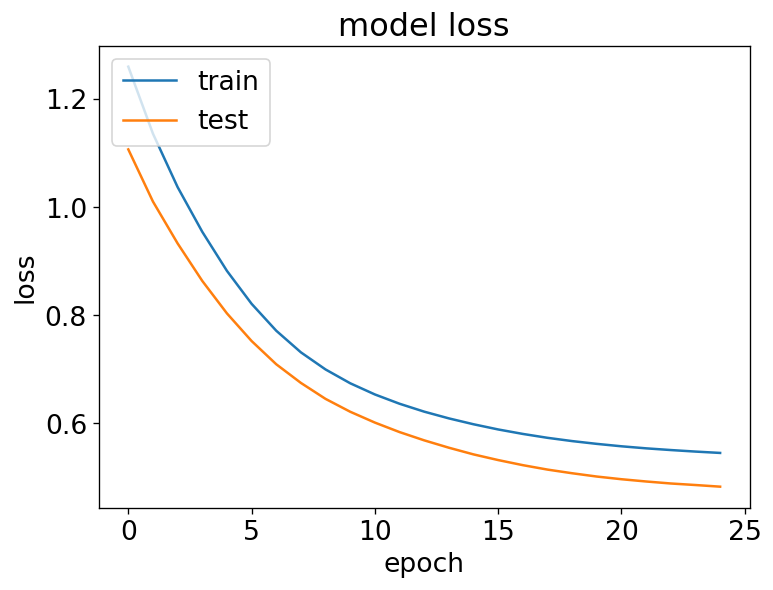

In [290]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [291]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict.reshape(-1,1))

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

10/10 [==============================] - 0s 4ms/step
Shape of train and test predict:  (934, 1) (312, 1)


In [292]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict)
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  0.7333394817629126 2.8493491392497106


In [293]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, test_predict))
print("MSE", mean_squared_error(y_test, test_predict))
print("RMSE", math.sqrt(mean_squared_error(y_test, test_predict)))

R2 score:  0.7831575574898646
MSE 3.6276809265765664
RMSE 1.904647192153068


 SMAPE prediction

In [294]:
print(smape(y_test, test_predict))

2.2021796273361476


 Direction Symmetry prediction

In [295]:
print(ds(y_test, test_predict))

82.63665594855306


 Theil's U coefficient prediction

In [296]:
print(u1(y_test, test_predict))

0.012682008329002651


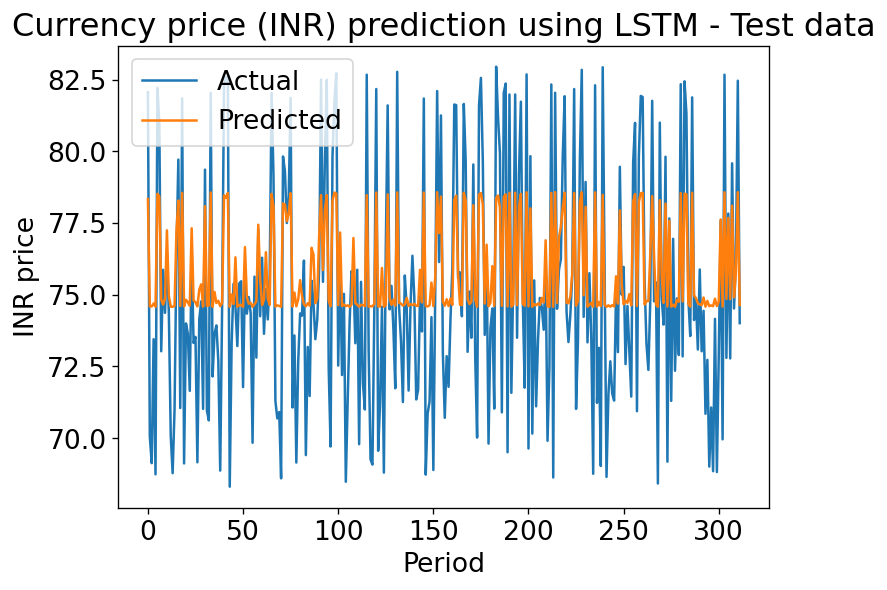

In [297]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# SARIMA

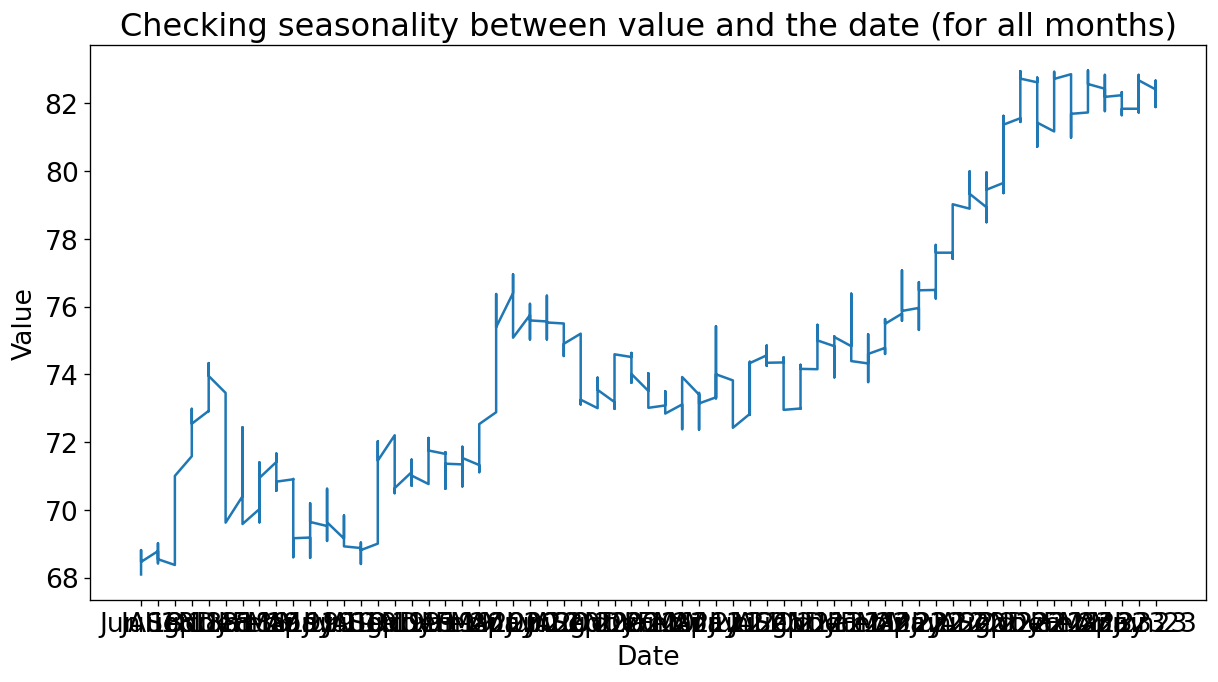

In [298]:
# Analysing for seasonality
from datetime import datetime
INR_dataset = pd.read_csv("DEXINUS.csv")
INR_dataset = INR_dataset.loc[INR_dataset['DEXINUS'] != '.' ]
INR_dataset['DEXINUS'] = INR_dataset['DEXINUS'].astype(float)
Date_column = [datetime.strptime(d, '%Y-%m-%d').strftime("%b %y") for d in INR_dataset['DATE']]
Day_column = [datetime.strptime(d, '%Y-%m-%d').strftime("%A") for d in INR_dataset['DATE']]

# Let's check for all the months for the exchange rate currency values in india
plt.figure(figsize=(12,6))
plt.plot(Date_column, INR_dataset['DEXINUS'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for all months)')
plt.show()

The graph is neither increasing or decreasing based on the months. So, let's check it for a particular week.

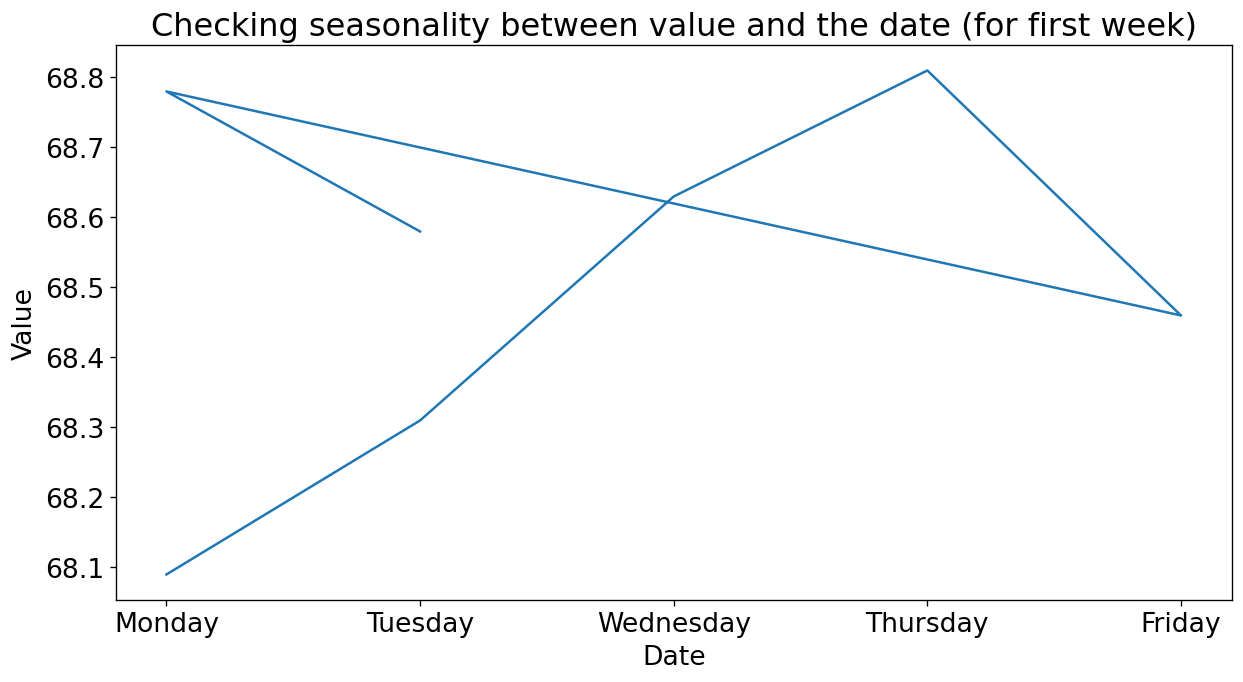

In [299]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[:7], INR_dataset['DEXINUS'][:7])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for first week)')
plt.show()

In week we get to see that the friday has the highest currency rate and it decreases as we move to weekends. So, let's check for multiple weeks and figure out about the days at which we get the higher currency rate from all the week days.

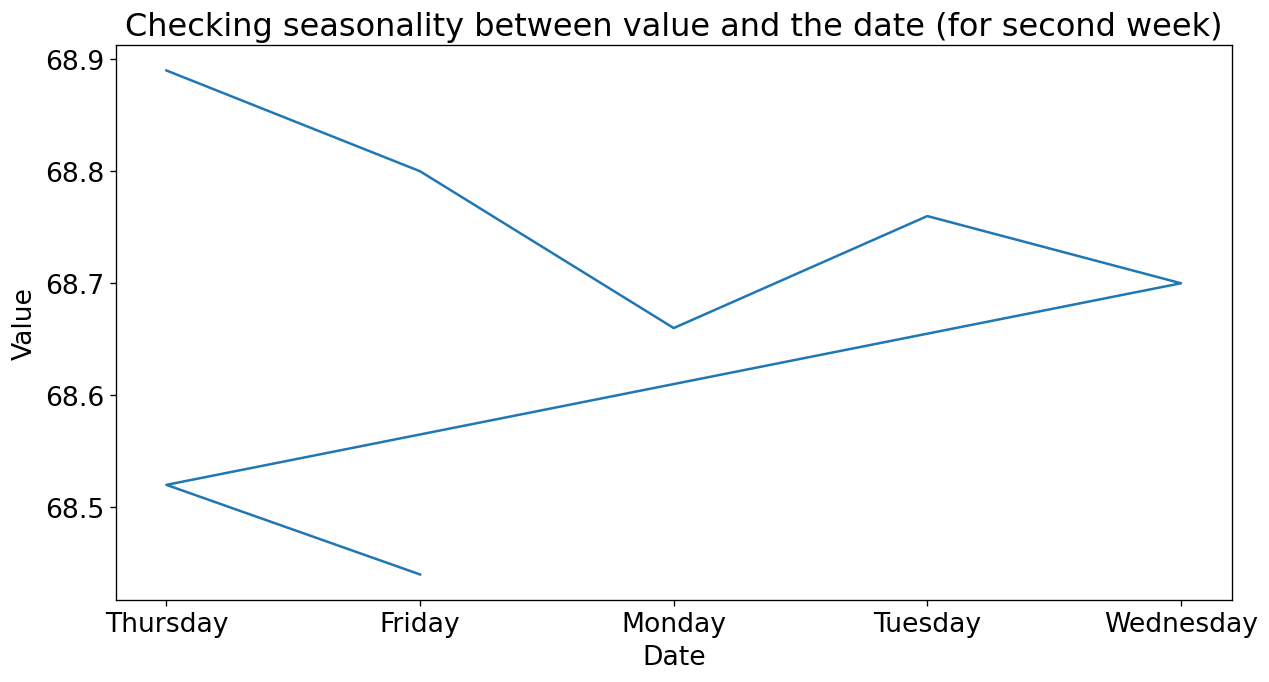

In [300]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[7:14], INR_dataset['DEXINUS'][7:14])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for second week)')
plt.show()

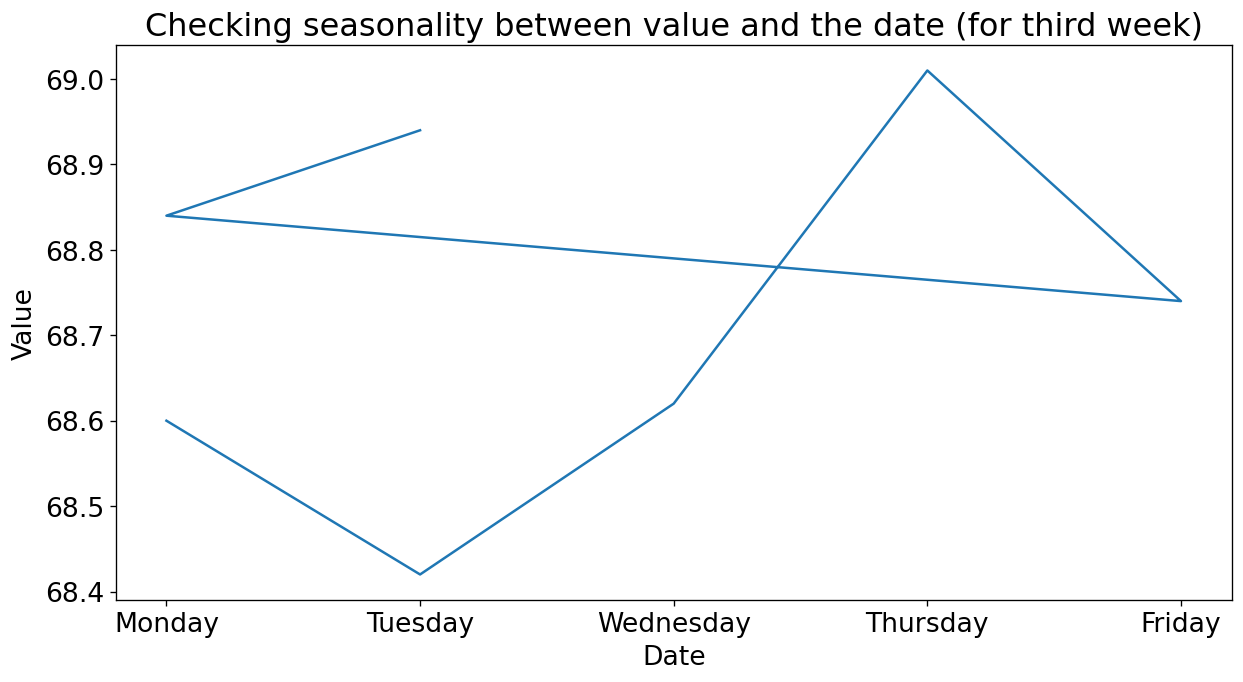

In [301]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[14:21], INR_dataset['DEXINUS'][14:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for third week)')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '2018-06-25'),
  Text(1, 0, '2018-06-26'),
  Text(2, 0, '2018-06-27'),
  Text(3, 0, '2018-06-28'),
  Text(4, 0, '2018-06-29'),
  Text(5, 0, '2018-07-02'),
  Text(6, 0, '2018-07-03'),
  Text(7, 0, '2018-07-05'),
  Text(8, 0, '2018-07-06'),
  Text(9, 0, '2018-07-09'),
  Text(10, 0, '2018-07-10'),
  Text(11, 0, '2018-07-11'),
  Text(12, 0, '2018-07-12'),
  Text(13, 0, '2018-07-13'),
  Text(14, 0, '2018-07-16'),
  Text(15, 0, '2018-07-17'),
  Text(16, 0, '2018-07-18'),
  Text(17, 0, '2018-07-19'),
  Text(18, 0, '2018-07-20'),
  Text(19, 0, '2018-07-23'),
  Text(20, 0, '2018-07-24')])

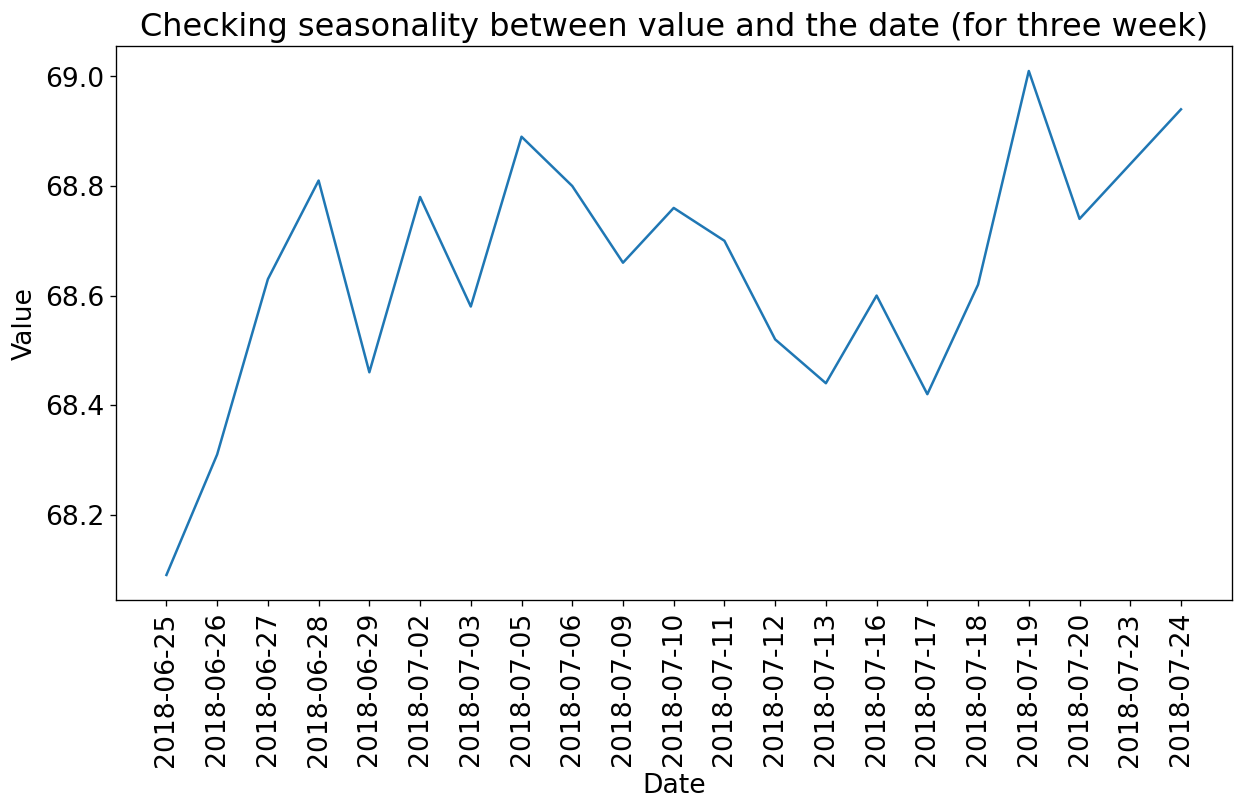

In [302]:
plt.figure(figsize=(12,6))
plt.plot(INR_dataset['DATE'][:21], INR_dataset['DEXINUS'][:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for three week)')
plt.xticks(rotation=90)

As, we can see in the graph the rate of currency increases highly when we move from the december 31st, 2021 to January 1st 2022 and same when we have festivals like the currency rate rapidly increased when we have christmas on 25th or 26th december. 
Hence, SARIMA can help us to predict ouput currency rate based on the seasonality. 

In [303]:
INR_dataset = INR_dataset.set_index('DATE')

In [304]:
INR_dataset.dtypes

DEXINUS    float64
dtype: object

In [305]:
INR_dataset = INR_dataset.iloc[:, :]
INR_dataset.head()

,DEXINUS
DATE,
2018-06-25,68.09
2018-06-26,68.31
2018-06-27,68.63
2018-06-28,68.81
2018-06-29,68.46


We have to calculate p, d, q, P, D, and Q value for the SARIMA to make the model for our forecasting

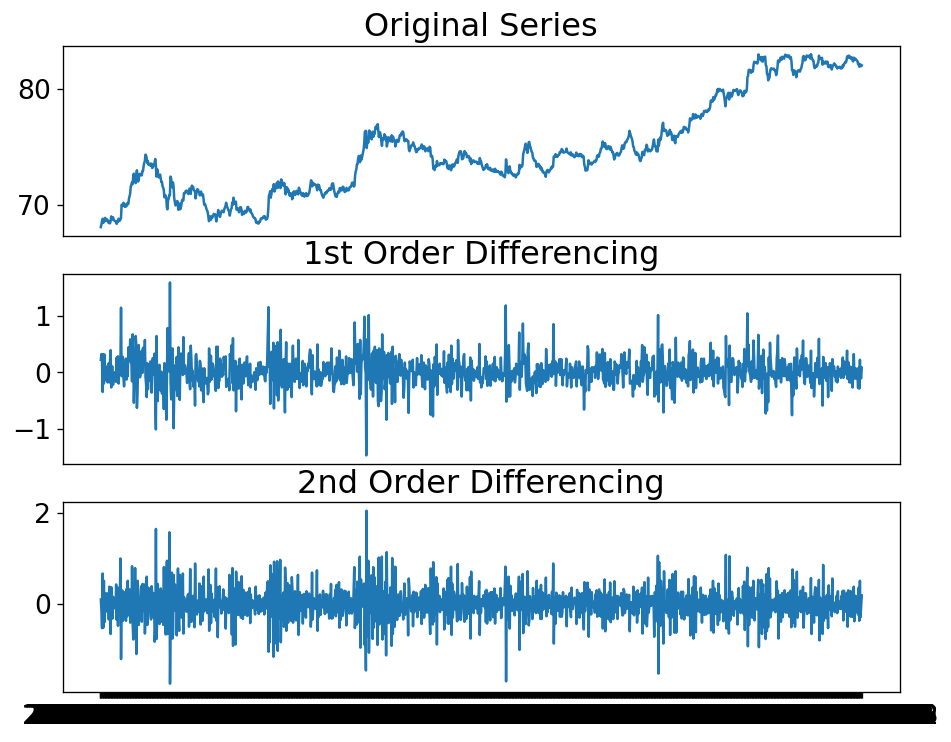

In [306]:
# Finding the d value
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(INR_dataset.DEXINUS); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(INR_dataset.DEXINUS.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(INR_dataset.DEXINUS.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In the first order differencing we have few noises than the second order differencing. So, we select the first order differencing for the model

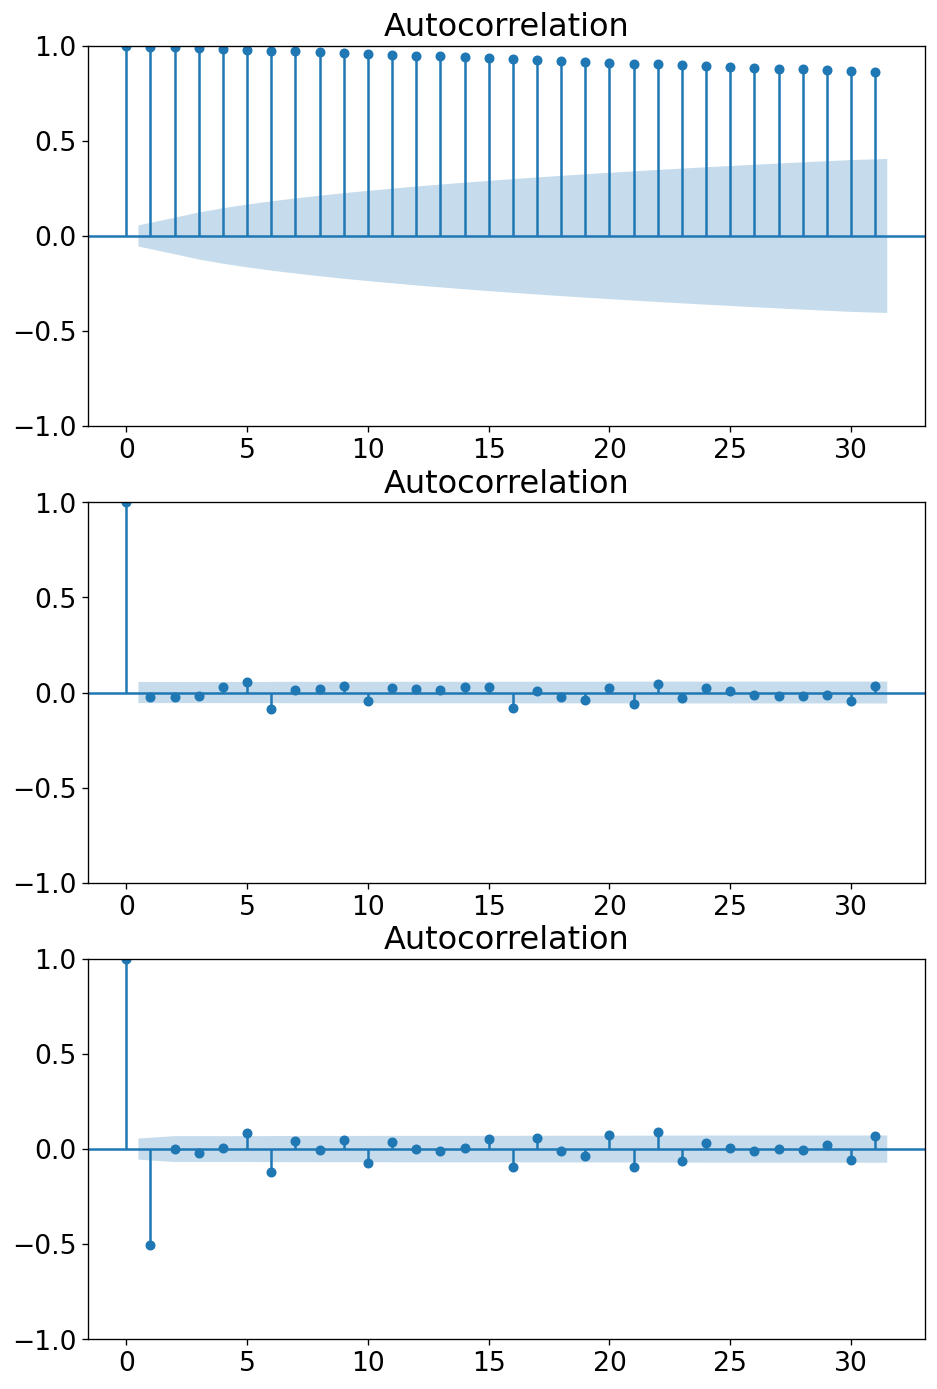

In [307]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({'figure.figsize':(9,14), 'figure.dpi':120})
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(INR_dataset.DEXINUS, ax=ax1)
plot_acf(INR_dataset.DEXINUS.diff().dropna(), ax=ax2)
plot_acf(INR_dataset.DEXINUS.diff().diff().dropna(), ax=ax3)
plt.show()

Here we can see that the second order differencing the immediate lag is gone to the negative side, representing that in second order the series has become over the difference.
Hence d = 1.

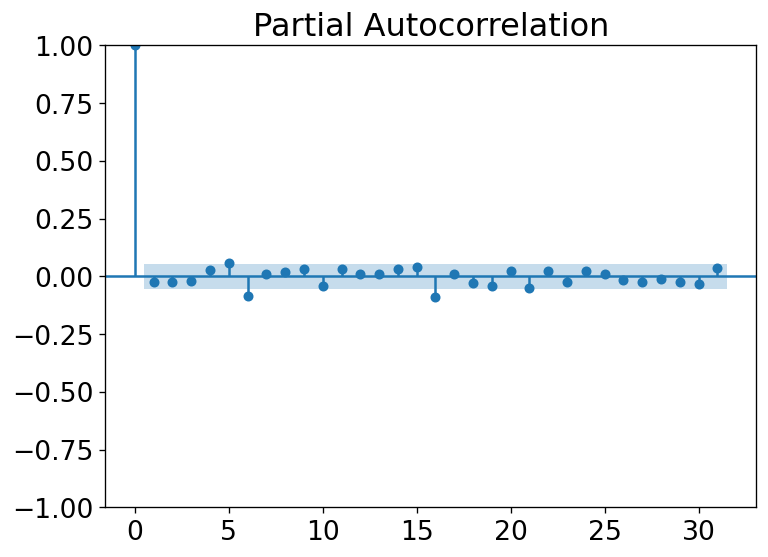

In [308]:
#Finding the p value
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams.update({'figure.figsize':(7, 5), 'figure.dpi':120})
plot_pacf(INR_dataset.DEXINUS.diff().dropna(), method='ywm')
plt.show()

Here we can see that the first lag is most significant than any other lags in the graph.
Hence p = 1.

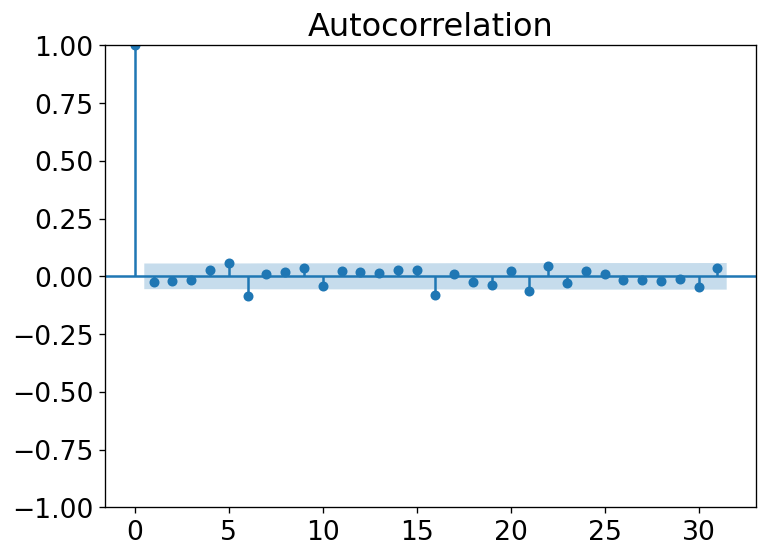

In [309]:
# Finding the q value

plot_acf(INR_dataset.DEXINUS.diff().dropna())
plt.show()

Here we can see that only 1 of the lag is out of significant limit.
Hence q = 1.

In [310]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(INR_dataset['DEXINUS'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            DEXINUS   No. Observations:                 1246
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -139.247
Date:                            Wed, 05 Jul 2023   AIC                            288.495
Time:                                    19:23:45   BIC                            314.081
Sample:                                         0   HQIC                           298.120
                                           - 1246                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3860      0.695      0.556      0.578      -0.975       1.747
ma.L1         -0.4131      0.684   

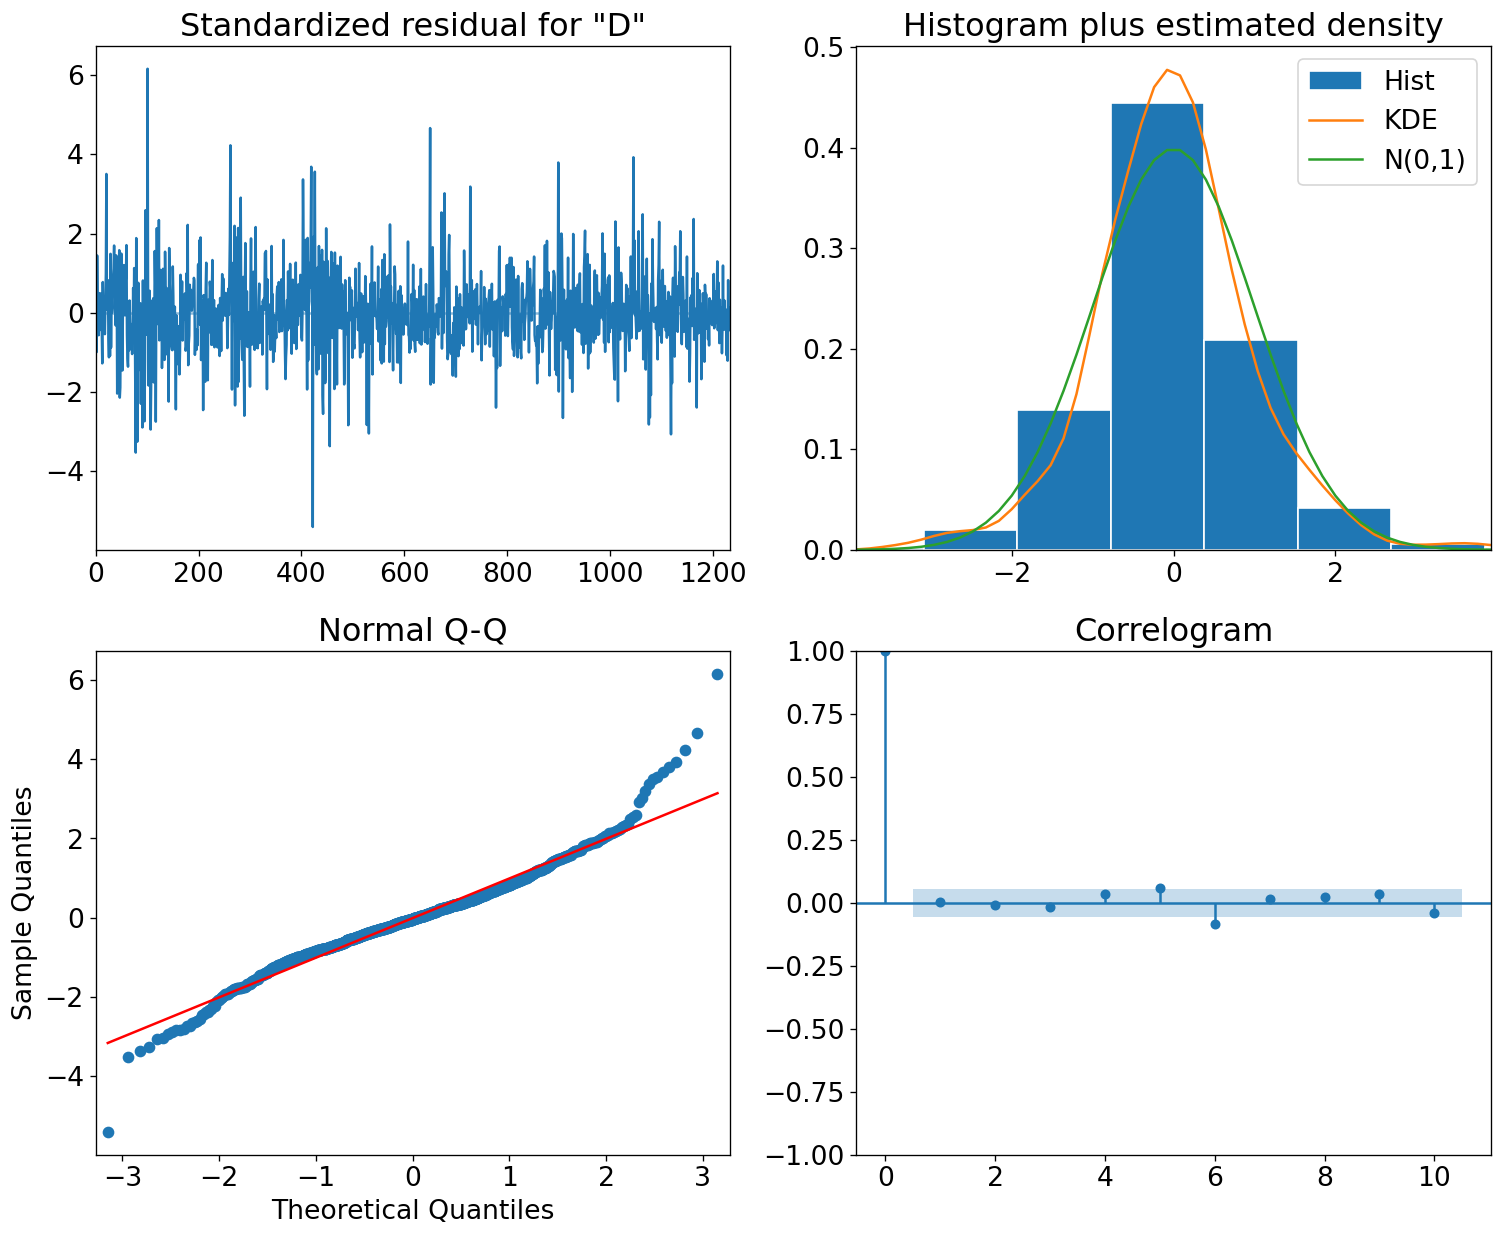

In [311]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [312]:
INR_dataset = pd.read_csv("DEXINUS.csv")
INR_dataset = INR_dataset.loc[INR_dataset['DEXINUS'] != '.' ]
INR_dataset['DEXINUS'] = INR_dataset['DEXINUS'].astype(float)
INR_dataset.head()

,DATE,DEXINUS
0,2018-06-25,68.09
1,2018-06-26,68.31
2,2018-06-27,68.63
3,2018-06-28,68.81
4,2018-06-29,68.46


In [313]:
INR_dataset = INR_dataset.reset_index()

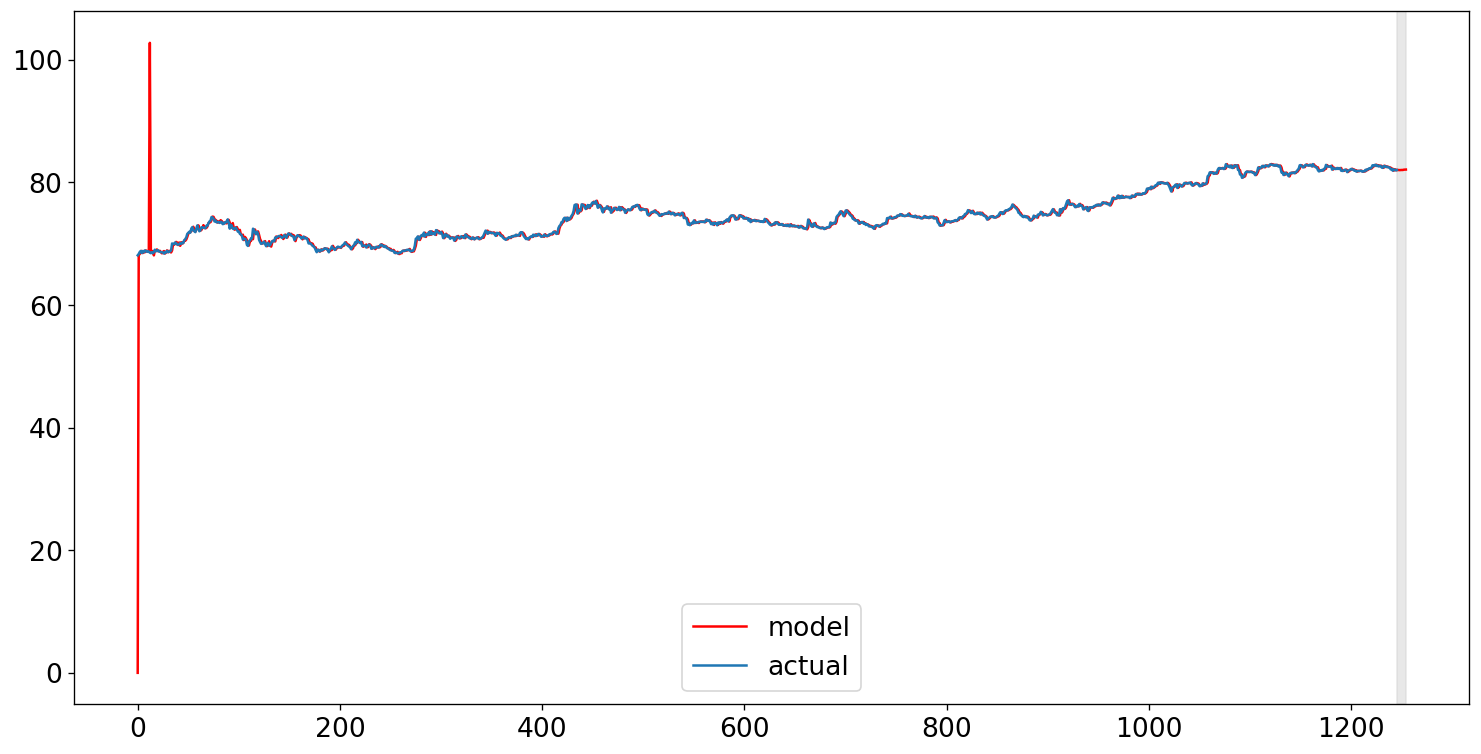

In [314]:
forecast = model.predict(start=0, end=INR_dataset.shape[0] + 8)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(INR_dataset.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(INR_dataset['DEXINUS'], label='actual')
plt.legend()
plt.show()

In [315]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

train = INR_dataset[:int(0.85*(len(INR_dataset)))]
test = INR_dataset[int(0.85*(len(INR_dataset))):]

start=len(train)
end=len(train)+len(test)-1
predictions = model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['DEXINUS'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['DEXINUS'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['DEXINUS'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['DEXINUS'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['DEXINUS'])
                                                               /np.abs(test['DEXINUS']))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.789795,0.166532,0.052539,0.229213,NaN


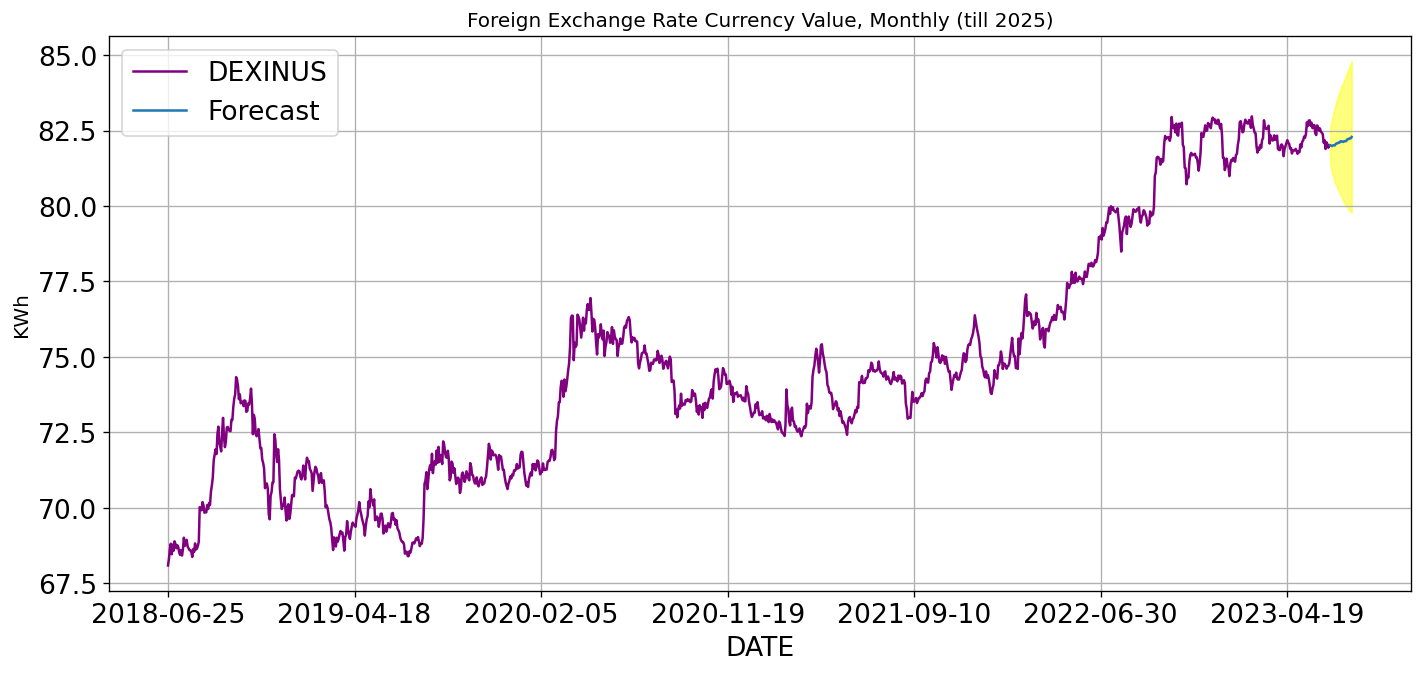

In [316]:
#Forecasting 2 years ahead
forecast_values = model.get_forecast(steps = 24)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = INR_dataset.plot(x='DATE', y='DEXINUS', figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Foreign Exchange Rate Currency Value, Monthly (till 2025)', size = 12)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left')
ax.axes.get_xaxis().set_visible(True)

plt.show()

Conclusion: From all the models I have tried the XGB regression was the best with R2 score around 93 none of the other models have score greater than 90 the SARIMA also have the score of 81 only.